In [1]:
import numpy as np

In [170]:
# L = number of base arms
L = 10

# d = dimension of context vectors
D = 5

# number of items to recommend to the user
K = 4

# H is some constant to balance.
H = 10

# time steps
T = 2

First, let us generate synthetic data.

Reference: https://github.com/wangbx66/contextual-bandit/blob/master/experiment.pdf

In [2265]:
def sample_spherical(n, d):
    " generate n random points on d-dimensional sphere with unit norm"
    v = np.random.randn(n, d)
    # v /= np.linalg.norm(v, axis=0)
    v /= np.linalg.norm(v, axis=1)[:, np.newaxis]
    return v

In [2284]:

class SyntheticEnv:
    def __init__(self, num_arms, dims, K, gamma = 1.0):
        self._dims = dims
        self._num_arms = num_arms
        self._theta = sample_spherical(1, self._dims - 1)[0]
        self._theta = np.append(self._theta, [[1]])
        self._theta /= 2
        self._K = K
        self._gamma = gamma
        
        ## IMP CHANGE
        self._theta /= self._K


    def get_theta(self):
        """return secret value of theta"""
        return self._theta
    
    def get_context(self):
        """get context matrix at a new time step"""
        X_t = sample_spherical(self._num_arms, self._dims - 1)
        X_t = np.c_[X_t, np.ones(self._num_arms)]
        return X_t
    
    def get_observed_weights(self, arms, context):
        """given context and list of arms return the list of observed 0/1 observed_weights"""
        weight_params = np.dot(self._theta, np.transpose(context))
        weight_params = weight_params[arms]
        # print(weight_params)
        weights = np.random.binomial(n=1,p=weight_params)
        # print(weights)
        pos_indices = np.nonzero(weights)
        if len(pos_indices[0]) > 0:
            weights = weights[:pos_indices[0][0] + 1]
        return weights
    
    def get_reward(self, weights):
        prod = 1.
        reward = 0.
        for i, w in enumerate(weights):
            reward += (self._gamma ** i) * prod * w
            prod *= 1 - w
        return reward
    
    def get_regret(self, arms, context, K):
        weight_params = np.dot(self._theta, np.transpose(context))
        best_arms = np.argsort(-weight_params)[:K]
                
        return self.get_reward(weight_params[best_arms]) - self.get_reward(weight_params[arms])


In [2409]:

class SyntheticEnvConjunctive:
    def __init__(self, num_arms, dims, K, gamma = 1.0):
        self._dims = dims
        self._num_arms = num_arms
        self._theta = sample_spherical(1, self._dims - 1)[0]
        self._theta = np.append(self._theta, [[1]])
        self._theta /= 2
        self._K = K
        
        self._gamma = gamma
        
        ## IMP CHANGE
        # self._theta /= self._K

    def get_theta(self):
        """return secret value of theta"""
        return self._theta
    
    def get_context(self):
        """get context matrix at a new time step"""
        X_t = sample_spherical(self._num_arms, self._dims - 1)
        X_t = np.c_[X_t, np.ones(self._num_arms)]
        return X_t
    
    def get_observed_weights(self, arms, context):
        """given context and list of arms return the list of observed 0/1 observed_weights"""
        weight_params = np.dot(self._theta, np.transpose(context))
        weight_params = weight_params[arms]
        # print(weight_params)
        weights = np.random.binomial(n=1,p=weight_params)

        # print(weights)
        zero_indices = np.where(weights == 0)[0]
        
        # print(zero_indices)
        if len(zero_indices) > 0:
            weights = weights[:zero_indices[0] + 1]
        return weights
    
    def get_reward(self, weights):
        prod = 1.
        reward = 0.
        # print("re weigh", weights)
        for i, w in enumerate(weights):
            reward += (1 - (self._gamma ** i)) * prod * (1 - w)
            prod *= w
        reward += prod
        return reward
    
    def get_regret(self, arms, context, K):
        weight_params = np.dot(self._theta, np.transpose(context))
        best_arms = np.argsort(-weight_params)[:K]
                
        return self.get_reward(weight_params[best_arms]) - self.get_reward(weight_params[arms])


In [2405]:
env = SyntheticEnvConjunctive(num_arms = 10, dims = 5, K = 4, gamma = 0.5)

print("theta: ", env.get_theta())
ctx = env.get_context()

print("weights: ", env.get_observed_weights(arms=[0,1,2,3], context=ctx))
print("reward: ", env.get_reward(env.get_observed_weights(arms=[0,1,2,3], context=ctx)))

# env.get_regret(arms=[1,2,4,6], context=ctx, K=4)
# env.get_reward([1,1,1,1])

theta:  [ 0.20176911 -0.0731947  -0.44986903  0.0393652   0.5       ]
weights:  [0]
re weigh [1 1 1 1]
reward:  1.0


In [2283]:
from sklearn.linear_model import Ridge

class Algorithm_C3_UCB:
    def __init__(self, num_arms, dims, K, gamma = 1.0):
        self._num_arms = num_arms
        self._dims = dims
        self._K = K
        self._gamma = gamma

        self._theta_hat = np.zeros(self._dims)
        self._beta = 0
        self._delta = 0.9
        self._lambda = 0.1
        self._V = self._lambda * np.eye(self._dims) # D x D
        _, self._logdetV = np.linalg.slogdet(self._V)
        self._X = np.zeros((1, self._dims)) # (num seen actions) x D
        self._Y = np.zeros(1) # (num seen actions)
        
        self._cumu_regret = np.zeros(1)
   
    def get_pca_norms(self, x):
        V_inv = np.linalg.inv(self._V)
        def norm_V(y):
            return np.linalg.multi_dot([y, V_inv, np.transpose(y)])
        return np.apply_along_axis(norm_V, 1, x) # [norm_V(x_a) for x_a in x]
    
    def get_confidence_bounds(self, context):
        # print("Getting confidence bounds.")
        weight_params_hat = np.dot(self._theta_hat, np.transpose(context))
        # print("weight_params_hat: ", weight_params_hat)
        ucbs = np.add(weight_params_hat, self.get_pca_norms(context))        
        ucbs = np.array([min(xi, 1) for xi in ucbs])
        return ucbs
    
    def get_cumulative_regret(self):
        return self._cumu_regret

    def step(self, env, time=None):
        # obtain context for all actions
        ctx = env.get_context()        
        ucbs = self.get_confidence_bounds(ctx)
        # get largest K actions
        chosen_actions = np.argsort(-ucbs)[:self._K]
                 
        observed_weights = env.get_observed_weights(arms=chosen_actions, context=ctx)
        self._cumu_regret = np.append(self._cumu_regret, 
                                      self._cumu_regret[-1] 
                                      + env.get_regret(arms=chosen_actions, context=ctx, K=self._K))
        # print("rewards: ", rewards)
        
        for i, w in enumerate(observed_weights):
            a = chosen_actions[i]
            g_pow_i = self._gamma ** i
            self._V = np.add(self._V, (g_pow_i ** 2) * np.outer(ctx[a], ctx[a]))
            self._X = np.vstack([self._X, g_pow_i * ctx[a]])
            self._Y = np.append(self._Y, g_pow_i * w)

        ridge = Ridge(alpha=self._lambda)
        ridge.fit(self._X, self._Y)
        self._theta_hat = ridge.coef_
        # print("theta_hat: ", self._theta_hat)
        # print("Actual theta: ", env.get_theta())
        # diff = np.subtract(self._theta_hat, env.get_theta())
        # print("dot product: ", np.dot(diff, diff))

        _, logdetV = np.linalg.slogdet(self._V)
        self._beta = np.sqrt(logdetV - (self._dims * np.log(self._lambda)) - (2 * np.log(self._delta)))
        self._beta += np.sqrt(self._lambda)

In [2270]:
class Algorithm_CombCascade:
    def __init__(self, num_arms, K):
        self._num_arms = num_arms
        self._K = K
        self._W = np.zeros(num_arms) # avg weights
        self._T = np.zeros(num_arms)
        
        self._cumu_regret = np.zeros(1)
       
    def get_confidence_bounds(self, time):
        # print("Getting confidence bounds.")
        eps = 1./ (self._num_arms * 100)
        lcbs = np.array([1. - self._W[i] - np.sqrt(1.5 * np.log(time) / max(eps, self._T[i]))
                  for i in range(self._num_arms)])
        lcbs = np.array([max(u, 0) for u in lcbs])
        return lcbs
        
        # ucbs = np.min(ucbs, 1)
    
    def get_cumulative_regret(self):
        return self._cumu_regret

    def step(self, env, time):
        # obtain context for all actions
        lcbs = self.get_confidence_bounds(time)
        # print("ucbs: ", ucbs)

        # get largest K actions
        chosen_arms = np.argsort(lcbs)[:self._K]
        
        # print("actions: ", chosen_actions)
        ctx = env.get_context()
        observed_weights = env.get_observed_weights(arms=chosen_arms, context=ctx)
        
        self._cumu_regret = np.append(self._cumu_regret, 
                                      self._cumu_regret[-1] 
                                      + env.get_regret(arms=chosen_arms, context=ctx, K=self._K))
        # print("rewards: ", rewards)
        
        for i, w in enumerate(observed_weights):
            a = chosen_arms[i]
            self._W[a] = (self._T[a] * self._W[a]) + (1 if i + 1 < len(observed_weights) else 0)
            self._T[a] += 1
            self._W[a] /= self._T[a]
                        
        # print(self._cumu_rewards)


In [2271]:
class Algorithm_Random:
    def __init__(self, num_arms, K):
        self._num_arms = num_arms
        self._K = K
        self._cumu_regret = np.zeros(1)
       
    def get_cumulative_regret(self):
        return self._cumu_regret

    def step(self, env, time=None):
        chosen_arms = np.random.choice(range(self._num_arms), size=self._K, replace=False)

        ctx = env.get_context()
        observed_weights = env.get_observed_weights(arms=chosen_arms, context=ctx)
        
        self._cumu_regret = np.append(self._cumu_regret, 
                                      self._cumu_regret[-1] 
                                      + env.get_regret(arms=chosen_arms, context=ctx, K=self._K))

In [2272]:
class Algorithm_CombCascade_Conjuctive:
    def __init__(self, num_arms, K):
        self._num_arms = num_arms
        self._K = K
        self._W = np.zeros(num_arms) # avg weights
        self._T = np.zeros(num_arms)
        
        self._cumu_regret = np.zeros(1)
       
    def get_confidence_bounds(self, time):
        # print("Getting confidence bounds.")
        eps = 1./ (self._num_arms * 100)
        ucbs = np.array([self._W[i] + np.sqrt(1.5 * np.log(time) / max(eps, self._T[i]))
                  for i in range(self._num_arms)])
        # print("LCBs: ", lcbs)
        
        ucbs = np.array([min(u, 1) for u in ucbs])
        # print(lcbs)
        return ucbs
        
        # ucbs = np.min(ucbs, 1)
    
    def get_cumulative_regret(self):
        return self._cumu_regret

    def step(self, env, time):
        # obtain context for all actions
        # print("Context: \n", ctx)
        
        ucbs = self.get_confidence_bounds(time)
        # print("ucbs: ", ucbs)

        # get largest K actions
        chosen_arms = np.argsort(-ucbs)[:self._K]
        
        # print("actions: ", chosen_actions)
        ctx = env.get_context()
        observed_weights = env.get_observed_weights(arms=chosen_arms, context=ctx)
        
        self._cumu_regret = np.append(self._cumu_regret, 
                                      self._cumu_regret[-1] 
                                      + env.get_regret(arms=chosen_arms, context=ctx, K=self._K))
        # print("rewards: ", rewards)
        
        for i, w in enumerate(observed_weights):
            a = chosen_arms[i]
            self._W[a] = (self._T[a] * self._W[a]) + (1 if i + 1 < len(observed_weights) else 0)
            self._T[a] += 1
            self._W[a] /= self._T[a]
                        
        # print(self._cumu_rewards)


In [2333]:
import csv
from collections import Counter
from collections import defaultdict
from itertools import chain
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds


class MovieLensEnv:
    def __init__(self, num_arms, dims, gamma = 1.0):

        self._history_matrix = None
        self._watch_future = None
        self._dims = dims
        self._num_arms = num_arms
        self._gamma = gamma

        self.populate(self.load_data())

    def populate(self, data):
        users = Counter() # list of user indices
        movies = Counter() # list of movies
        
        frac_train = 0.5
        watch_history = defaultdict()
        watch_future = defaultdict()
        
        entry_count = 0
        for user, movie, _, _ in data:
            user, movie = int(user), int(movie)
            users[user] += 1
            movies[movie] += 1
            
            if np.random.random_sample() < frac_train:
                watch_history[(user, movie)] = 1
            else:
                watch_future[(user, movie)] = 1
            
            entry_count += 1
            if entry_count > 100000:
                break
                
        print("Num users: ", len(users))
        print("Num movies: ", len(movies))

        self.select_movies(users=users, movies=movies, watch_history=watch_history, watch_future=watch_future, num_to_select=self._num_arms)       
        # print("Watch history", self._watch_history)
        # print("Watch future", self._watch_future)
        
        self.do_pca()
        print("History matrix shape: ", self._history_matrix.shape)
        
            
    def select_movies(self, users, movies, watch_history, watch_future, num_to_select):
        # print("100 most common movies: ", movies.most_common(num_to_select))
        
        selected_movies = [ m for (m, _) in movies.most_common(num_to_select)] # IMP change this number
        selected_movies_hash = defaultdict()
        for i, m in enumerate(selected_movies):
            selected_movies_hash[m] = i
        
        users_hash = defaultdict()
        for i, u in enumerate(users.keys()):
            users_hash[u] = i


        # print("Selected movies: ", selected_movies)
        # print("Users hash: ", users_hash)
        # print("Selected movies hash: ", selected_movies_hash)

        self._watch_history = defaultdict()
        for (u, m) in watch_history.keys():
            if m in selected_movies:
                self._watch_history[(users_hash[u], selected_movies_hash[m])] = 1
                
        self._watch_future = defaultdict()
        for (u, m) in watch_future.keys():
            if m in selected_movies:
                self._watch_future[(users_hash[u], selected_movies_hash[m])] = 1
        
    def do_pca(self):
        history_users = [u for (u, m) in self._watch_history.keys()]
        history_movies = [m for (u, m) in self._watch_history.keys()]
        history_data = [1] * len(self._watch_history)
        
        # print(history_users, history_movies, history_data)
        self._history_matrix = coo_matrix((history_data, (history_users, history_movies)), dtype=np.float32)
        print("hist shape ", self._history_matrix.shape)
        
        self._history_U, _, VT = svds(self._history_matrix, k=self._dims)
        self._history_V = VT.T

        print("hist U shape ", self._history_U.shape)
        print("hist V shape ", self._history_V.shape)

    def load_data(self):
        ratings_file = open('ratings.csv', encoding='utf-8')
        tags_file = open('tags.csv', encoding='utf-8')
        # ['userId', 'movieId', 'rating', 'timestamp']
        ratings_csv = csv.reader(ratings_file, delimiter=',', quotechar='"')
        # ['userId', 'movieId', 'tag', 'timestamp']
        tags_csv = csv.reader(tags_file, delimiter=',', quotechar='"')
        
        ratings_csv.__next__()
        tags_csv.__next__()
        
        # treat both tags and ratings as features
        return chain(tags_csv, ratings_csv)

    def get_theta(self):
        """return secret value of theta"""
        return None
    
    def get_context(self):
        """get context matrix at a new time step"""
        num_users = self._history_U.shape[0]
        
        self._user = -1
        while self._user < 0 or np.count_nonzero(self._history_U[self._user]) == 0:
            self._user = np.random.choice(range(num_users))
            
        # context should be num_arms x dims^2
        
        # ith row contains outer product of user and movie
        ctx = np.zeros((self._num_arms, self._dims ** 2))
        for i in range(self._num_arms):
            ctx[i] = np.outer(self._history_U[self._user], self._history_V[i]).flatten()
            # print("U: ", self._history_U[user])
            # print("V: ", self._history_V[i])
            # print("ctx[i]: ", ctx[i])

        # print("out shape: ", out.shape)
        # print("out: ", out)
        # print("Chose user: ", user)
        # print("ctx shape: ", ctx.shape)
        # print("ctx: ", ctx)        
        return ctx
    
    def get_observed_weights(self, arms, context=None):
        """given list of arms return the list of observed 0/1 observed_weights"""
        weights = [1 if (self._user, a) in self._watch_future else 0 for a in arms]
        # print("weights: ", weights)
        return weights
    
    def get_reward(self, weights):
        rewards = [(self._gamma ** i) * w for i, w in enumerate(weights)]
        # print(weights, rewards)
        return sum(rewards)

    def get_regret(self, arms, context=None, K=None): # actually reward!
        return self.get_reward(self.get_observed_weights(arms=arms))


In [2330]:
movie_env = MovieLensEnv(num_arms = 20, dims = 4, gamma = 0.5)

ctx = movie_env.get_context()

# print(ctx)

print("Weights: ", movie_env.get_observed_weights(arms = list(range(4))))
print("Reward: ", movie_env.get_regret(arms = list(range(4))))

Num users:  1502
Num movies:  8235
hist shape  (1502, 20)
hist U shape  (1502, 4)
hist V shape  (20, 4)
History matrix shape:  (1502, 20)
Weights:  [0, 0, 0, 0]
[0, 0, 0, 0] [0.0, 0.0, 0.0, 0.0]
Reward:  0.0


In [2428]:
from sklearn.linear_model import Ridge

class Algorithm_C3_UCB_GD:
    def __init__(self, num_arms, dims, K):
        self._num_arms = num_arms
        self._dims = dims
        self._K = K
        
        self._theta_hat = np.zeros(self._dims)
        self._beta = 0
        self._delta = 0.9
        self._lambda = 0.1
        self._V = self._lambda * np.eye(self._dims) # D x D
        _, self._logdetV = np.linalg.slogdet(self._V)
        self._X = np.zeros((1, self._dims)) # (num seen actions) x D
        self._Y = np.zeros(1) # (num seen actions)
        
        self._cumu_regret = np.zeros(1)
        self._num_entries = 1000
        self._alpha = 0.1
   
    def get_pca_norms(self, x):
        V_inv = np.linalg.inv(self._V)
        def norm_V(y):
            return np.linalg.multi_dot([y, V_inv, np.transpose(y)])
        return np.apply_along_axis(norm_V, 1, x) # [norm_V(x_a) for x_a in x]
    
    def get_confidence_bounds(self, context):
        weight_params_hat = np.dot(self._theta_hat, np.transpose(context))
        ucbs = np.add(weight_params_hat, self.get_pca_norms(context))
        ucbs = np.array([min(xi, 1) for xi in ucbs])
        return ucbs
    
    def get_cumulative_regret(self):
        return self._cumu_regret

    def step(self, env, time=None):
        ctx = env.get_context()
        ucbs = self.get_confidence_bounds(ctx)
        # get largest K actions
        chosen_actions = np.argsort(-ucbs)[:self._K]
        observed_weights = env.get_observed_weights(arms=chosen_actions, context=ctx)

        self._cumu_regret = np.append(self._cumu_regret, 
                                      self._cumu_regret[-1] 
                                      + env.get_regret(arms=chosen_actions, context=ctx, K=self._K))
        
        for i, w in enumerate(observed_weights):
            a = chosen_actions[i]
            self._V = np.add(self._V, np.outer(ctx[a], ctx[a]))
            self._X = np.vstack([self._X, ctx[a]])
            self._Y = np.append(self._Y, w)
            
        # Keep the last _num_entries entries!
        num_remove = max(self._X.shape[0] - self._num_entries, 0)
        self._X = self._X[num_remove:, ...]
        self._Y = self._Y[num_remove:]
            
        Y_hat = np.matmul(self._X, self._theta_hat)
        gradient = np.matmul(self._X.T, np.add(Y_hat, -self._Y))
        
        # print("Y: ", self._Y)
        # print("Y_hat: ", Y_hat)
        error = Y_hat - self._Y
        gradient = self._X.T.dot(error) / self._X.shape[0]
        self._theta_hat -= self._alpha * gradient
        self._alpha *= 0.999
        
        # print("Error: ", error.dot(error) / error.shape[0])
        
        # ridge = Ridge(alpha=self._lambda)
        # ridge.fit(self._X, self._Y)
        # self._theta_hat = ridge.coef_
        
        # compute self._theta_hat based on gradient descent.
        
        
        # print("theta_hat: ", self._theta_hat)
        # print("actual theta: ", env.get_theta())
        
        # diff = np.subtract(self._theta_hat, env.get_theta())
        # print("dot product: ", np.dot(diff, diff))

        # self._all_rewards = np.append(self._all_rewards, rewards)
        # print(self._cumu_rewards)


In [2342]:
class Algorithm_C3_UCB_KF:
    def __init__(self, num_arms, dims, K, gamma = 1.0):
        self._num_arms = num_arms
        self._dims = dims
        self._K = K
        self._gamma = gamma
        
        self._theta_hat = np.zeros(self._dims)
        self._beta = 0
        self._delta = 0.9
        self._lambda = 0.1
        self._V = self._lambda * np.eye(self._dims) # D x D
        _, self._logdetV = np.linalg.slogdet(self._V)
        self._X = np.zeros((1, self._dims)) # (num seen actions) x D
        self._Y = np.zeros(1) # (num seen actions)
        
        self._sigma = (self._lambda * self._lambda) * np.eye(self._dims) # D x D

        self._cumu_regret = np.zeros(1)
   
    def get_pca_norms(self, x):
        V_inv = np.linalg.inv(self._V)
        def norm_V(y):
            return np.linalg.multi_dot([y, V_inv, np.transpose(y)])
        return np.apply_along_axis(norm_V, 1, x) # [norm_V(x_a) for x_a in x]
    
    def get_confidence_bounds(self, context):
        # print("Getting confidence bounds.")
        weight_params_hat = np.dot(self._theta_hat, np.transpose(context))
        # print("weight_params_hat: ", weight_params_hat)
        ucbs = np.add(weight_params_hat, self.get_pca_norms(context))
        
        ucbs = np.array([min(xi, 1) for xi in ucbs])
        return ucbs
    
        # ucbs = np.min(ucbs, 1)
    
    def get_cumulative_regret(self):
        return self._cumu_regret
    
    def kalman_update(self, params, weight, gamma):
        """update theta_hat and sigma"""
        # print("weight: ", weight)
        params *= gamma
        weight *= gamma
        
        variance = 0.5
        denom = params.dot(self._sigma.dot(params)) + variance        
        numer = np.outer(self._sigma.dot(params), params)
        
        self._theta_hat = (np.eye(self._dims) - (numer/denom)).dot(self._theta_hat)
        self._theta_hat += weight * (self._sigma.dot(params) / denom)
        # print("_theta_hat", self._theta_hat)
        
        self._sigma -= numer.dot(self._sigma) / denom

        # print("_sigma", self._sigma)

        
    def step(self, env, time=None):
        # obtain context for all actions
        ctx = env.get_context()
        # print("Context: \n", ctx)
        
        ucbs = self.get_confidence_bounds(ctx)
        # print("ucbs: ", ucbs)

        # get largest K actions
        chosen_actions = np.argsort(-ucbs)[:self._K]         
        observed_weights = env.get_observed_weights(arms=chosen_actions, context=ctx)
        self._cumu_regret = np.append(self._cumu_regret, 
                                      self._cumu_regret[-1] 
                                      + env.get_regret(arms=chosen_actions, context=ctx, K=self._K))
        
        for i, w in enumerate(observed_weights):
            a = chosen_actions[i]
            self._V = np.add(self._V, np.outer(ctx[a], ctx[a]))
            self._X = np.vstack([self._X, ctx[a]])
            self._Y = np.append(self._Y, w)
            
            self.kalman_update(ctx[a], w, gamma = self._gamma ** i)
                
        _, logdetV = np.linalg.slogdet(self._V)
        self._beta = np.sqrt(logdetV - (self._dims * np.log(self._lambda)) - (2 * np.log(self._delta)))
        self._beta += np.sqrt(self._lambda)

In [2350]:
# Evaluate MovieLens

NUM_ARMS = 200
DIMS = 25
SUGG_SIZE = 4
GAMMA = 0.25

env3 = MovieLensEnv(num_arms = NUM_ARMS, dims = 5, gamma=GAMMA)
alg1 = Algorithm_C3_UCB(num_arms = NUM_ARMS, dims = DIMS, K = SUGG_SIZE, gamma=GAMMA)
alg2 = Algorithm_CombCascade(num_arms = NUM_ARMS, K = SUGG_SIZE)
alg3 = Algorithm_C3_UCB_GD(num_arms = NUM_ARMS, dims = DIMS, K = SUGG_SIZE)
alg4 = Algorithm_Random(num_arms = NUM_ARMS, K = SUGG_SIZE)
alg5 = Algorithm_C3_UCB_KF(num_arms = NUM_ARMS, dims = DIMS, K = SUGG_SIZE, gamma=GAMMA)
alg6 = Algorithm_C3_UCB_KF(num_arms = NUM_ARMS, dims = DIMS, K = SUGG_SIZE, gamma=1.0)
alg7 = Algorithm_C3_UCB(num_arms = NUM_ARMS, dims = DIMS, K = SUGG_SIZE, gamma=1.0)

T = 10000
for t in range(1, T + 1):
    if t % 100 == 0:
        print("Time: ", t)
    alg1.step(env3, t)
    alg2.step(env3, t)
    alg3.step(env3, t)
    alg4.step(env3, t)
    alg5.step(env3, t)
    alg6.step(env3, t)
    alg7.step(env3, t)


Num users:  1502
Num movies:  8235
hist shape  (1502, 200)
hist U shape  (1502, 5)
hist V shape  (200, 5)
History matrix shape:  (1502, 200)
Time:  100
Time:  200
Time:  300
Time:  400
Time:  500
Time:  600
Time:  700
Time:  800
Time:  900
Time:  1000
Time:  1100
Time:  1200
Time:  1300
Time:  1400
Time:  1500
Time:  1600
Time:  1700
Time:  1800
Time:  1900
Time:  2000
Time:  2100
Time:  2200
Time:  2300
Time:  2400
Time:  2500
Time:  2600
Time:  2700
Time:  2800
Time:  2900
Time:  3000
Time:  3100
Time:  3200
Time:  3300
Time:  3400
Time:  3500
Time:  3600
Time:  3700
Time:  3800
Time:  3900
Time:  4000
Time:  4100
Time:  4200
Time:  4300
Time:  4400
Time:  4500
Time:  4600
Time:  4700
Time:  4800
Time:  4900
Time:  5000
Time:  5100
Time:  5200
Time:  5300
Time:  5400
Time:  5500
Time:  5600
Time:  5700
Time:  5800
Time:  5900
Time:  6000
Time:  6100
Time:  6200
Time:  6300


KeyboardInterrupt: 

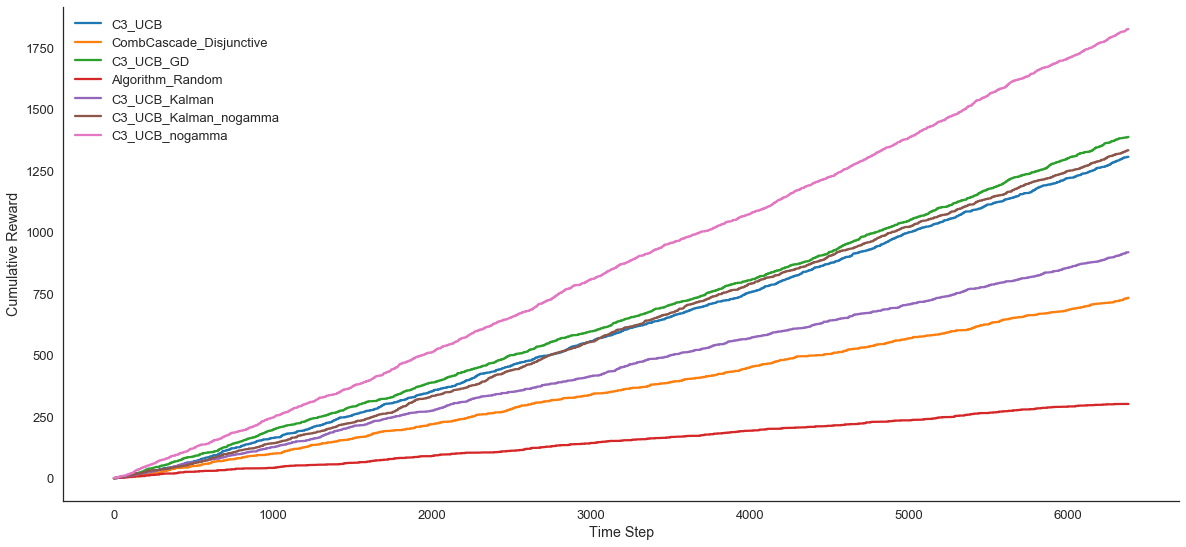

In [2351]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(20,20))
plt.subplot(2, 1, 1)
plt.plot(alg1.get_cumulative_regret())
plt.plot(alg2.get_cumulative_regret())
plt.plot(alg3.get_cumulative_regret())
plt.plot(alg4.get_cumulative_regret())
plt.plot(alg5.get_cumulative_regret())
plt.plot(alg6.get_cumulative_regret())
plt.plot(alg7.get_cumulative_regret())

plt.legend(['C3_UCB', 'CombCascade_Disjunctive','C3_UCB_GD',
            'Algorithm_Random', 'C3_UCB_Kalman', 'C3_UCB_Kalman_nogamma', 'C3_UCB_nogamma'],
           loc=0)

plt.ylabel('Cumulative Reward')
plt.xlabel('Time Step')

sns.despine()
plt.show()


In [2429]:
## Evaluate Synthetic Disjuctive

NUM_ARMS = 10
DIMS = 5
SUGG_SIZE = 3
GAMMA = 0.5

env3 = SyntheticEnv(num_arms = NUM_ARMS, dims = DIMS, K = SUGG_SIZE, gamma = GAMMA)
alg1 = Algorithm_C3_UCB(num_arms = NUM_ARMS, dims = DIMS, K = SUGG_SIZE)
alg2 = Algorithm_CombCascade(num_arms = DIMS, K = SUGG_SIZE)
alg3 = Algorithm_C3_UCB_GD(num_arms = NUM_ARMS, dims = DIMS, K = SUGG_SIZE)
alg4 = Algorithm_Random(num_arms = NUM_ARMS, K = SUGG_SIZE)
alg5 = Algorithm_C3_UCB_KF(num_arms = NUM_ARMS, dims = DIMS, K = SUGG_SIZE)
alg6 = Algorithm_C3_UCB(num_arms = NUM_ARMS, dims = DIMS, K = SUGG_SIZE, gamma=GAMMA)
alg7 = Algorithm_C3_UCB_KF(num_arms = NUM_ARMS, dims = DIMS, K = SUGG_SIZE, gamma=GAMMA)

T = 2000
for t in range(1, T + 1):
    if t % 100 == 0:
        print("Time: ", t)
    alg1.step(env3, t)
    alg2.step(env3, t)
    alg3.step(env3, t)
    alg4.step(env3, t)
    alg5.step(env3, t)
    alg6.step(env3, t)
    alg7.step(env3, t)



Time:  100
Time:  200
Time:  300
Time:  400
Time:  500
Time:  600
Time:  700
Time:  800
Time:  900
Time:  1000
Time:  1100
Time:  1200
Time:  1300
Time:  1400
Time:  1500
Time:  1600
Time:  1700
Time:  1800
Time:  1900
Time:  2000


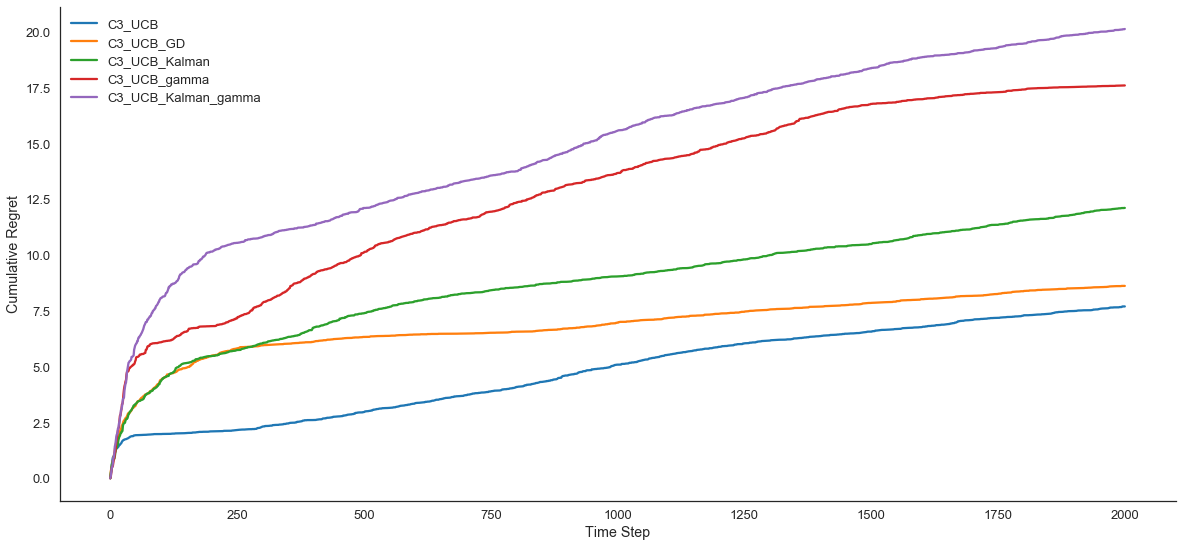

In [2430]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(20,20))
plt.subplot(2, 1, 1)
plt.plot(alg1.get_cumulative_regret())
# plt.plot(alg2.get_cumulative_regret())
plt.plot(alg3.get_cumulative_regret())
# plt.plot(alg4.get_cumulative_regret())
plt.plot(alg5.get_cumulative_regret())
plt.plot(alg6.get_cumulative_regret())
plt.plot(alg7.get_cumulative_regret())

# plt.legend(['C3_UCB', 'CombCascade_Disjunctive','C3_UCB_GD', 'Algorithm_Random', 'C3_UCB_Kalman', 'C3_UCB_nog'], loc=0)
plt.legend(['C3_UCB','C3_UCB_GD', 'C3_UCB_Kalman', 'C3_UCB_gamma', 'C3_UCB_Kalman_gamma'], loc=0)

plt.ylabel('Cumulative Regret')
plt.xlabel('Time Step')

# plt.plot(optimal * 100)
sns.despine()
plt.show()

In [2419]:
# Evaluate Conjunctive
NUM_ARMS = 200
DIMS = 20
SUGG_SIZE = 4
GAMMA = 0.9

env = SyntheticEnvConjunctive(num_arms = NUM_ARMS, dims = DIMS, K = SUGG_SIZE, gamma = GAMMA)

alg1 = Algorithm_C3_UCB(num_arms = NUM_ARMS, dims = DIMS, K = SUGG_SIZE)
alg2 = Algorithm_CombCascade_Conjuctive(num_arms = DIMS, K = SUGG_SIZE)
alg3 = Algorithm_C3_UCB_GD(num_arms = NUM_ARMS, dims = DIMS, K = SUGG_SIZE)
alg4 = Algorithm_Random(num_arms = NUM_ARMS, K = SUGG_SIZE)
alg5 = Algorithm_C3_UCB_KF(num_arms = NUM_ARMS, dims = DIMS, K = SUGG_SIZE)
alg6 = Algorithm_C3_UCB(num_arms = NUM_ARMS, dims = DIMS, K = SUGG_SIZE, gamma=GAMMA)
alg7 = Algorithm_C3_UCB_KF(num_arms = NUM_ARMS, dims = DIMS, K = SUGG_SIZE, gamma=GAMMA)

T = 1000
for t in range(1, T + 1):
    if t % 100 == 0:
        print("Time: ", t)
    alg1.step(env, t)
    alg2.step(env, t)
    alg3.step(env, t)
    alg4.step(env, t)
    alg5.step(env, t)
    alg6.step(env, t)
    alg7.step(env, t)


Time:  100
Time:  200
Time:  300
Time:  400
Time:  500
Time:  600
Time:  700
Time:  800
Time:  900
Time:  1000


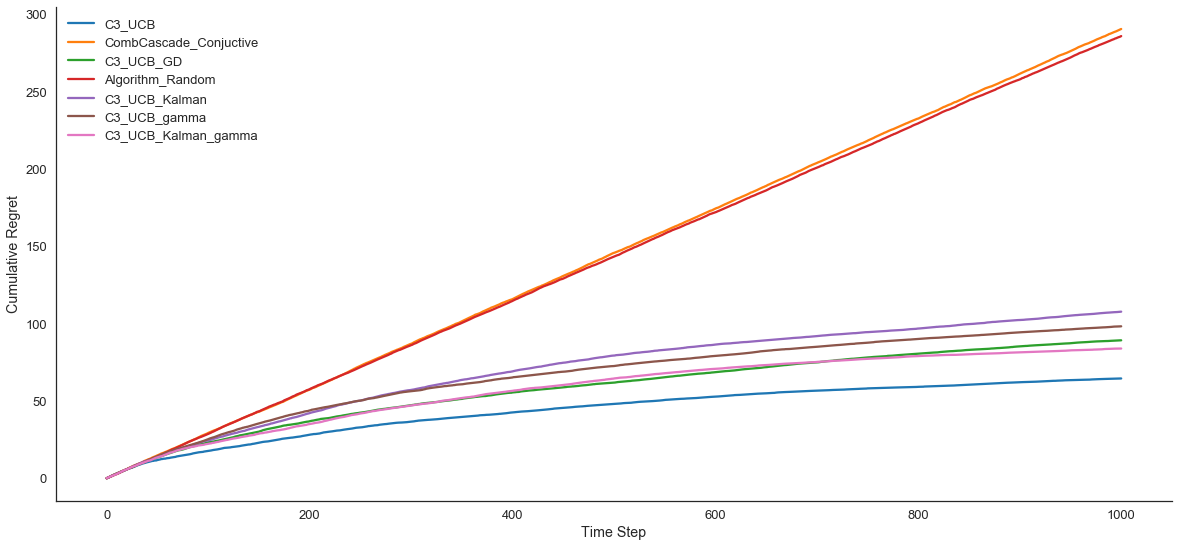

In [2420]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(20,20))
plt.subplot(2, 1, 1)
plt.plot(alg1.get_cumulative_regret())
plt.plot(alg2.get_cumulative_regret())
plt.plot(alg3.get_cumulative_regret())
plt.plot(alg4.get_cumulative_regret())
plt.plot(alg5.get_cumulative_regret())
plt.plot(alg6.get_cumulative_regret())
plt.plot(alg7.get_cumulative_regret())

plt.legend(['C3_UCB', 'CombCascade_Conjuctive','C3_UCB_GD', 'Algorithm_Random', 'C3_UCB_Kalman', 'C3_UCB_gamma',
           'C3_UCB_Kalman_gamma'], loc=0)

plt.ylabel('Cumulative Regret')
plt.xlabel('Time Step')

# plt.plot(optimal * 100)
sns.despine()
plt.show()